In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import sys
sys.bvlablabla
import data_processing as dp
import head_direction.head as head
import spatial_maps as sp
import pnnmec.registration
import speed_cells.speed as spd
import re
import joblib
from distutils.dir_util import copy_tree
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pnnmec
import scipy.ndimage.measurements
import quantities as pq
import exdir
from tqdm import tqdm_notebook as tqdm

ModuleNotFoundError: No module named 'septum_mec'

In [3]:
%matplotlib inline

In [4]:
max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size=0.02
smoothing = 0.05

In [5]:
project_path = dp.project_path()

project = expipe.get_project(project_path)
actions = project.actions

In [6]:
output_path = pathlib.Path("output") / "plot-all-cells"
(output_path / "figures").mkdir(exist_ok=True, parents=True)

In [7]:
statistics_action = actions['calculate-statistics']
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(session_units, statistics_results, how='left')
statistics.head()

action  baseline  entity  frequency      i    ii  session  \
0  1849-060319-3      True    1849        NaN  False  True        3   
1  1849-060319-3      True    1849        NaN  False  True        3   
2  1849-060319-3      True    1849        NaN  False  True        3   
3  1849-060319-3      True    1849        NaN  False  True        3   
4  1849-060319-3      True    1849        NaN  False  True        3   

  stim_location  stimulated          tag  ...  burst_event_ratio  \
0           NaN       False  baseline ii  ...           0.397921   
1           NaN       False  baseline ii  ...           0.146481   
2           NaN       False  baseline ii  ...           0.373466   
3           NaN       False  baseline ii  ...           0.097464   
4           NaN       False  baseline ii  ...           0.248036   

  bursty_spike_ratio  gridness  border_score  information_rate  \
0           0.676486 -0.459487      0.078474          0.965845   
1           0.277121 -0.615405      0.311180          0.191375   
2           0.658748 -0.527711      0.131660          3.833587   
3           0.196189 -0.641543      0.274989          0.153740   
4           0.461250 -0.085292      0.198676          0.526720   

   information_specificity  head_mean_ang head_mean_vec_len   spacing  \
0                 0.309723       5.788704          0.043321  0.624971   
1                 0.032266       1.821598          0.014624  0.753333   
2                 0.336590       4.407614          0.121115  0.542877   
3                 0.068626       6.128601          0.099223  0.484916   
4                 0.033667       1.602362          0.051825  0.646571   

   orientation  
0    22.067900  
1     0.000000  
2    27.758541  
3    11.309932  
4     0.000000  

[5 rows x 39 columns]

In [8]:
statistics['date'] = statistics.apply(lambda x: x.action.split('-')[1], axis=1)

In [9]:
statistics['unit_day'] = statistics.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

# Quick verification of results

In [10]:
data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=True, baseline_duration=600,
)

In [49]:
from scipy.interpolate import interp1d
def summarize(row, value):
    action_id = row['action']
    channel_id = int(row['channel_group'])
    unit_id = int(row['unit_name'])
    
    cell_name = "{}_{}_{}".format(action_id, channel_id, unit_id)
    
    action = actions[action_id]
    data_path = pathlib.Path(project_path) / "actions" / action_id / "data" / "main.exdir"

    
    # common values for all units == faster calculations
    x, y, t, speed = map(data_loader.tracking(action_id).get, ['x', 'y', 't', 'v'])
    
    spike_times = data_loader.spike_train(action_id, channel_id, unit_id)
    
    title = "{}\n{}: {:.2f}".format(cell_name, value, row[value], )
    
    if value not in ["head_mean_vec_len", 'speed_score']:
        spatial_map = sp.SpatialMap(x, y, t, spike_times, box_size=1.0, bin_size=0.02)
        rate_map = spatial_map.rate_map(0.03)
        plt.imshow(rate_map)
        
#         plt.plot(x, y, alpha=.5, color='grey')
        plt.xticks([])
        plt.yticks([])
#         sx = interp1d(t, x)(spike_times)
#         sy = interp1d(t, y)(spike_times)
#         plt.scatter(sx, sy, color='r', s=1)
#         plt.xlim(0,1)
#         plt.ylim(0,1)
#         plt.gca().set_aspect(1)
    elif value == "head_mean_vec_len":
        ang, ang_t = map(data_loader.head_direction(action_id).get, ['a', 't'])
        ang_bin, ang_rate = head.head_direction_rate(spike_times, ang, ang_t)
        head_mean_ang, head_mean_vec_len = head.head_direction_score(ang_bin, ang_rate)
        plt.plot(ang_bin, ang_rate)
        title = title + '\n'
    else:
        binsize = 0.02
        speed_score, inst_speed, rate, times = spd.speed_correlation(
            speed, t, spike_times, return_data=True)
        speed_bins = np.arange(min_speed, max_speed + binsize, binsize)
        ia = np.digitize(inst_speed, bins=speed_bins, right=True)
        mean_rate = np.zeros_like(speed_bins)
        for i in range(len(speed_bins)):
            mean_rate[i] = np.mean(rate[ia==i])
        
        plt.plot(speed_bins, mean_rate)
        aspect = (max_speed - min_speed) / (np.nanmax(mean_rate) - np.nanmin(mean_rate))
        plt.gca().set_aspect(aspect)
        
#     plt.title(title)

def top(df, value):
    projection = 'polar' if value == 'head_mean_vec_len' else None
    
    top = df.sort_values(by='action', ascending=True)
    counter = 1
    n_cols = 12
    n_rows = np.ceil(len(top) / n_cols).astype(int)
    fig = plt.figure(figsize=(16, 30))
    for index, row in top.iterrows():
        plt.subplot(n_rows, n_cols, counter, projection=projection)
        summarize(row, value)
        counter += 1
    plt.tight_layout()
    fig.savefig(output_path / f'all-{value}.png', bbox_inches='tight')

In [37]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
quantiles_99 = pd.read_csv(shuffling.data_path('quantiles_99'))

In [38]:
action_columns = ['action', 'channel_group', 'unit_name']
data_95 = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

data_99 = pd.merge(statistics, quantiles_99, on=action_columns, suffixes=("", "_threshold"))

In [39]:


# output_exdir = exdir.File(shuffling.data_path('shuffling'))
# output_units = output_exdir.require_group("units")

# quantiles = []

# for cell_id, cell in output_units.items():
#     results = cell['results']
#     shuffling_data_path = results.root_directory / results.relative_path / "shuffling_data.csv"
#     shuffling_data = pd.read_csv(shuffling_data_path)
#     quantile = shuffling_data.quantile(0.97, axis=0)
    
#     def add_attrs(quantile):
#         quantile['action'] = cell.attrs['action']
#         quantile['channel_group'] = cell.attrs['channel_group']
#         quantile['unit_name'] = cell.attrs['unit_name']
    
#     add_attrs(quantile)
        
#     quantiles.append(quantile)
    
# quantiles = pd.DataFrame(quantiles)

In [40]:
# data_96 = pd.merge(statistics, quantiles, on=action_columns, suffixes=("", "_threshold"))

In [41]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold_95 = data_95.query(query)
print("Number of gridcells 95", len(sessions_above_threshold_95))

# sessions_above_threshold_96 = data_96.query(query)
# print("Number of gridcells 96", len(sessions_above_threshold_96))

sessions_above_threshold_99 = data_99.query(query)
# sessions_above_threshold_99 = data_99.query(query)
print("Number of gridcells 99", len(sessions_above_threshold_99))


gridness_above_threshold_95 = data_95.query('gridness > gridness_threshold')
print("Number of gridcells", len(gridness_above_threshold_95))

information_rate_above_threshold_99 = data_99.query('information_rate > information_rate_threshold')
# sessions_above_threshold_99 = data_99.query(query)
print("Number of gridcells", len(information_rate_above_threshold_99))

Number of gridcells 95 225
Number of gridcells 99 68
Number of gridcells 265
Number of gridcells 167


In [42]:
once_a_gridcell_95 = statistics[statistics.unit_day.isin(sessions_above_threshold_95.unit_day.values)]
print("Number of gridcells", gridcell_sessions.unit_idnum.nunique())
print("Number of gridcell recordings", len(gridcell_sessions))
print("Number of animals", len(gridcell_sessions.groupby(['entity'])))

(271, 40)

In [43]:
# on = [k for k in gridness_above_threshold_95 if not k.endswith('_threshold')]
# sessions_above_threshold = gridness_above_threshold_95.loc[:,on].merge(
#     information_rate_above_threshold_99.loc[:,on])
# once_a_gridcell = statistics[statistics.unit_id.isin(sessions_above_threshold.unit_id.values)]

In [44]:
# excluded = old_once_a_gridcell[~old_once_a_gridcell.isin(once_a_gridcell)].dropna(axis=0, how='all')

In [45]:
# len(excluded), len(old_once_a_gridcell) - len(once_a_gridcell)

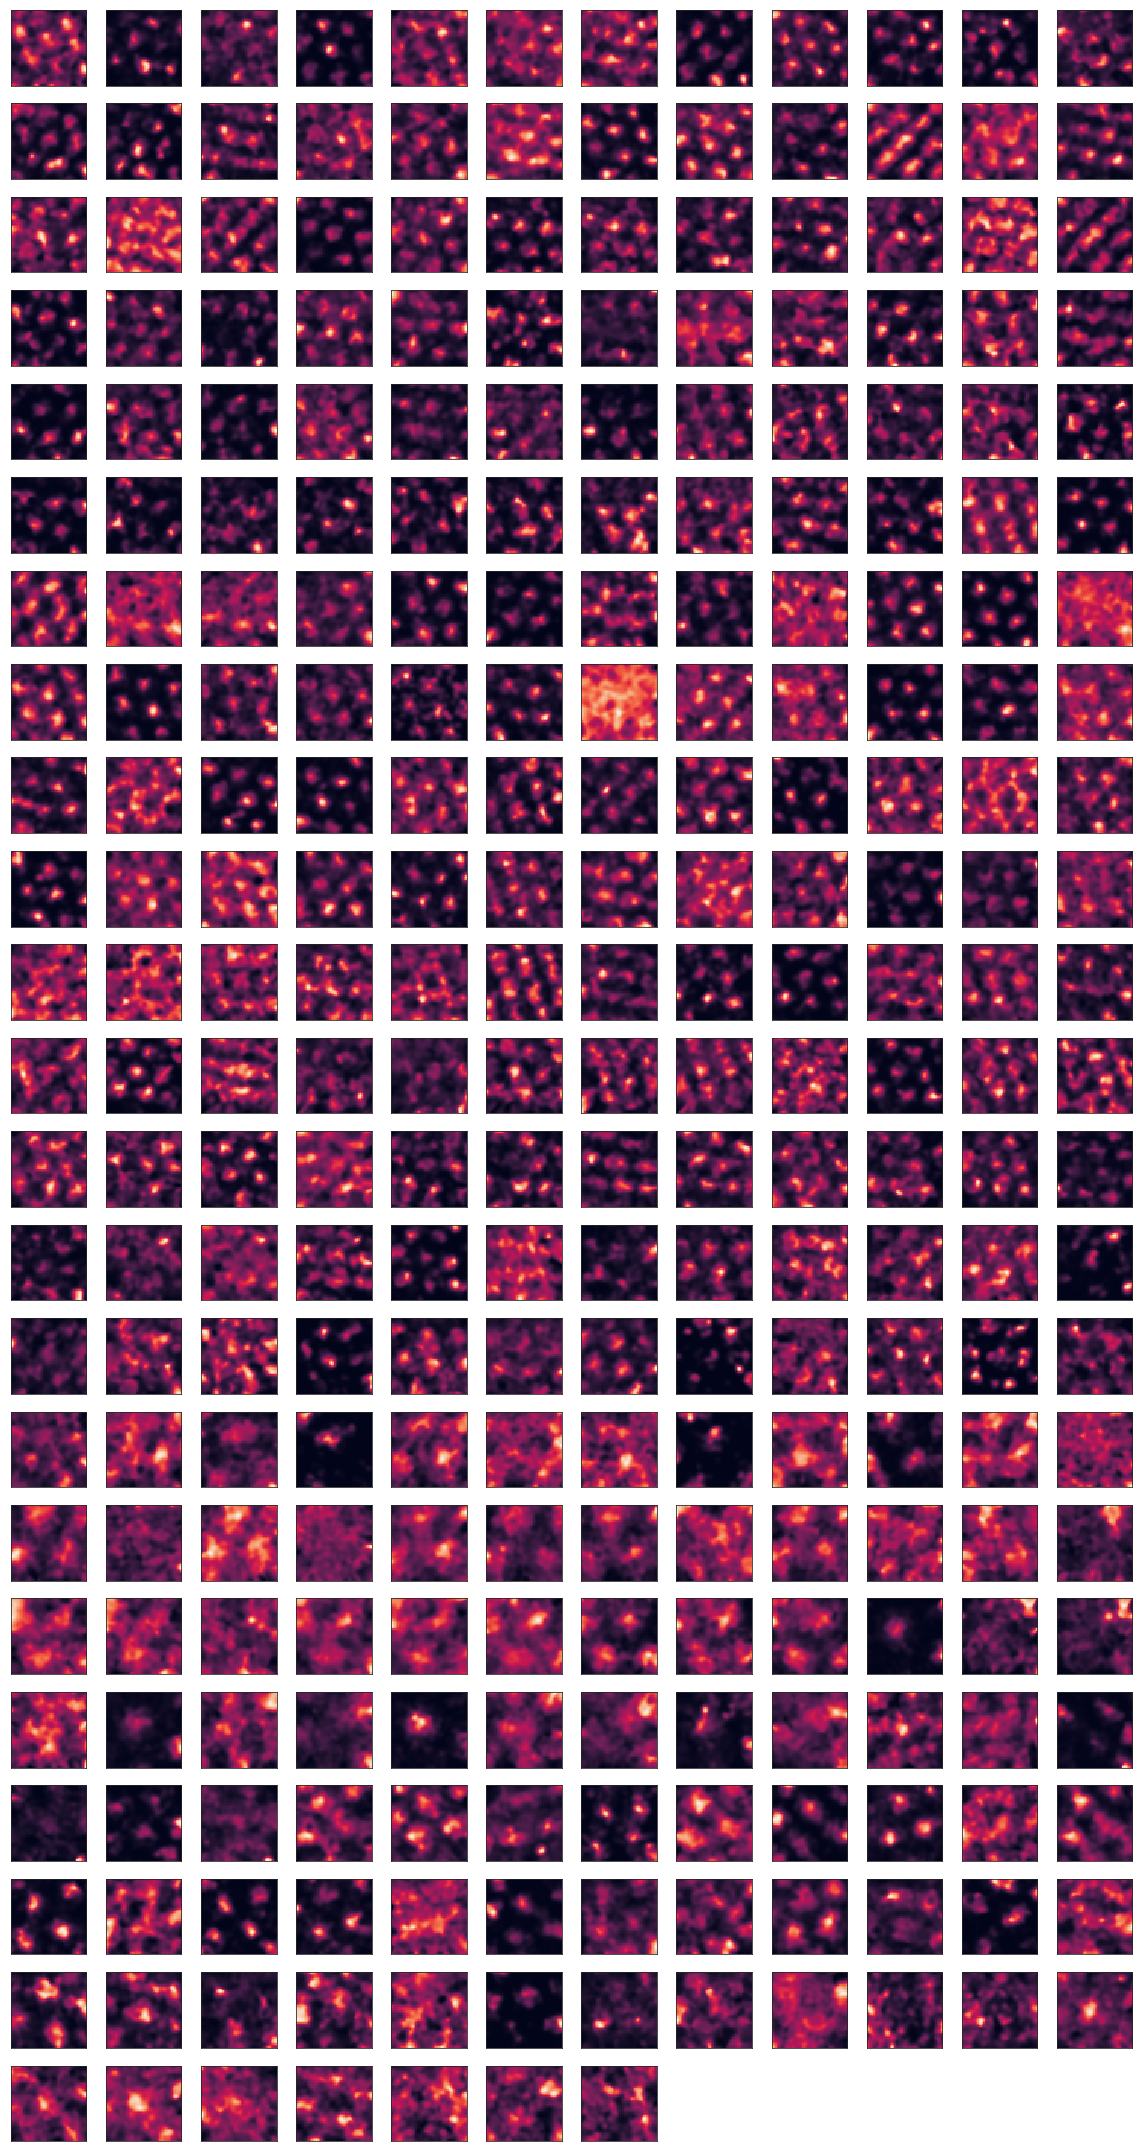

In [50]:
top(once_a_gridcell_95, "gridness")

# Plot by day

In [20]:
max_speed = 1, # m/s only used for speed score
min_speed = 0.02, # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size = 0.02
smoothing_low = 0.03
smoothing_high = 0.06

data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size
)

In [21]:
def session_id(row):
    if row.baseline and row.i:
        n = 0
    elif row.stimulated and row.i:
        n = 1
    elif row.baseline and row.ii:
        n = 2
    elif row.stimulated and row.ii:
        n = 3
    else:
        raise ValueError('what')
    return n
        
once_a_gridcell_95['session_id'] = once_a_gridcell_95.apply(session_id, axis=1)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


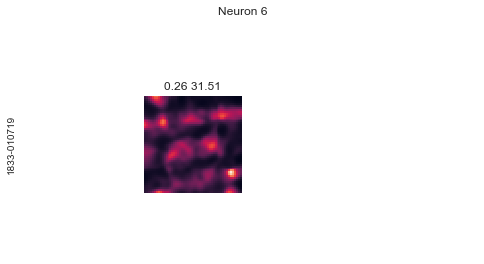

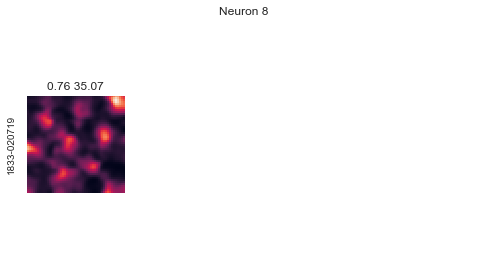

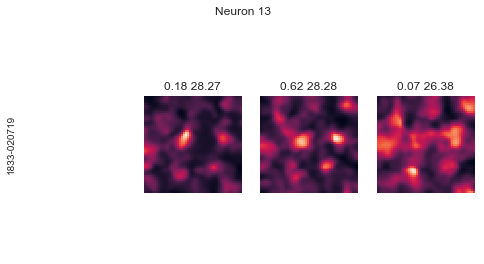

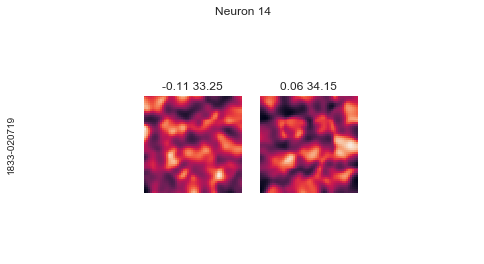

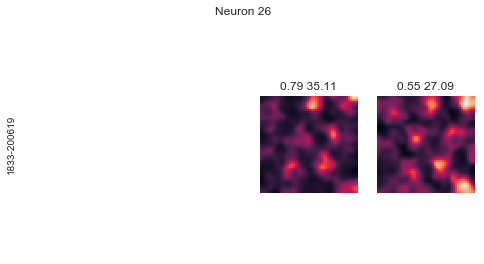

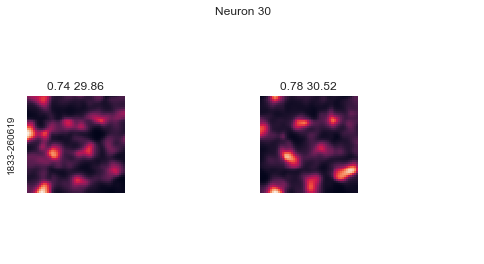

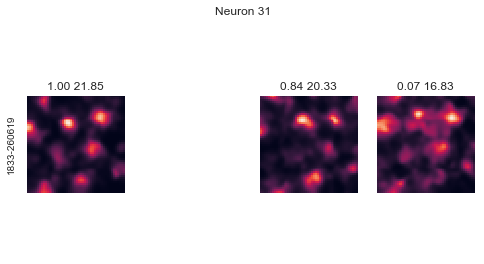

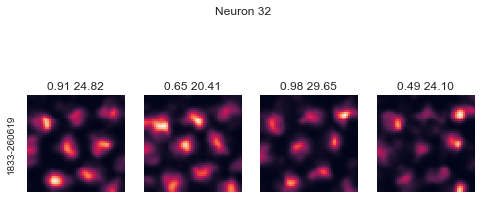

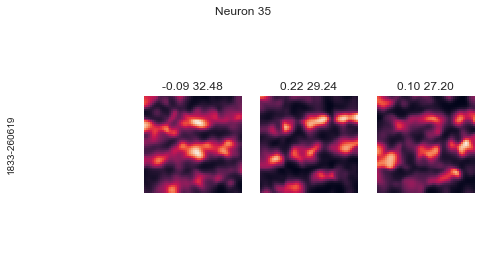

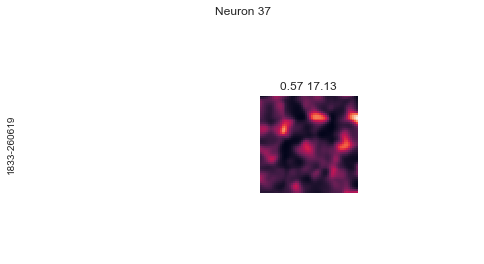

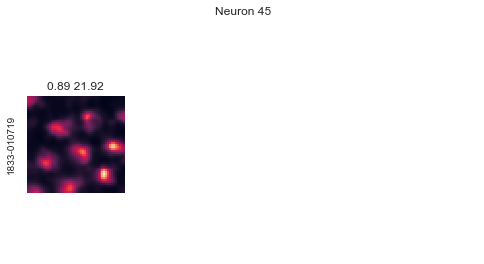

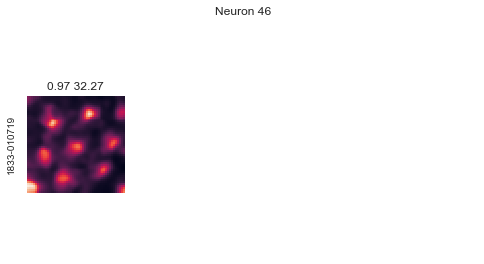

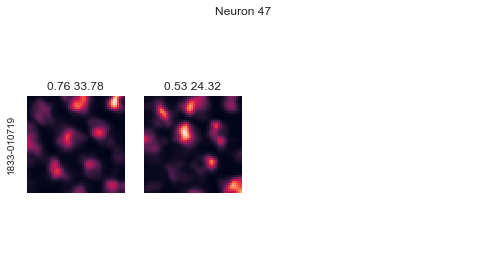

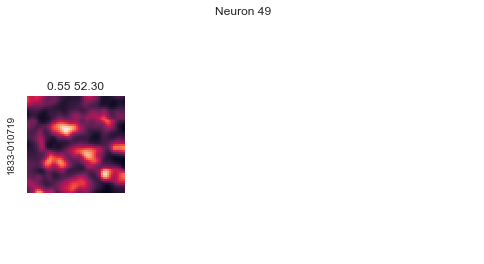

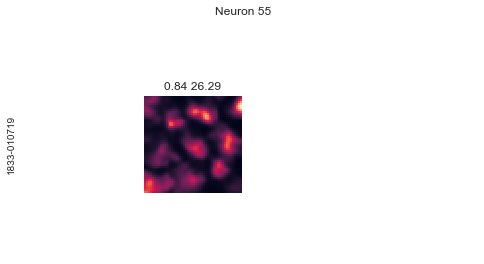

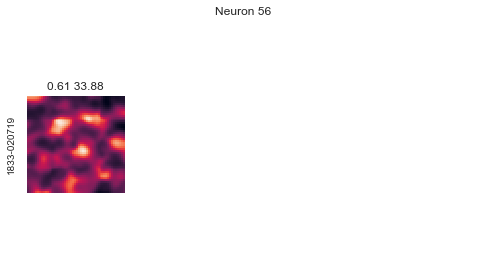

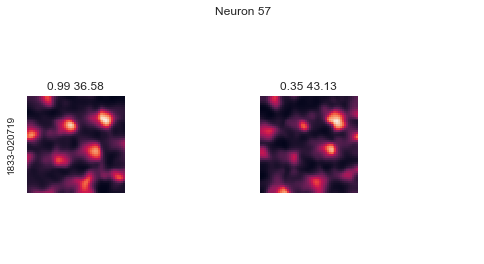

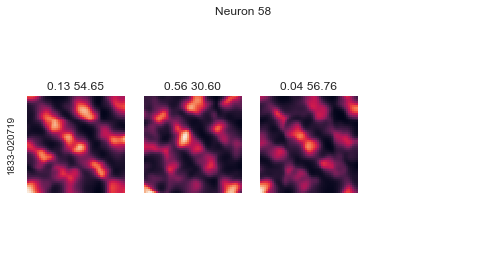

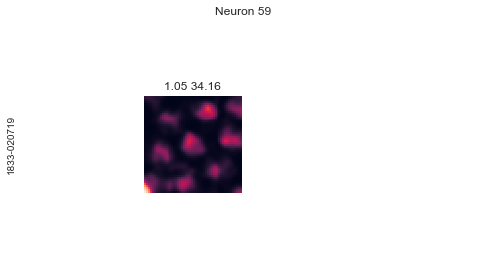

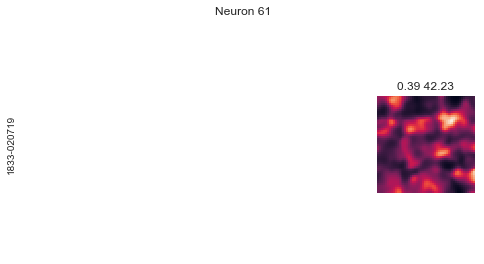

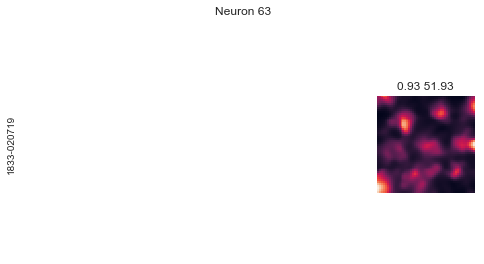

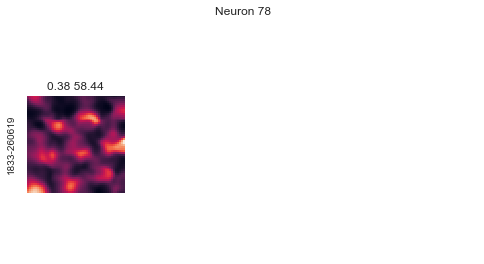

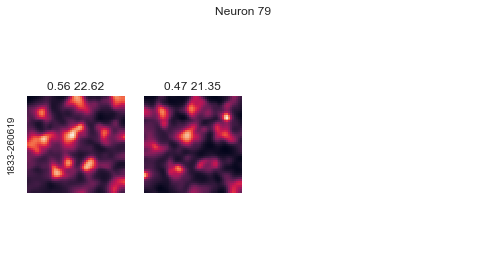

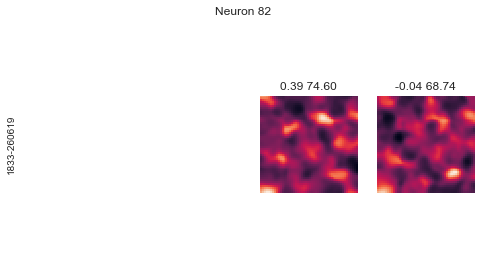

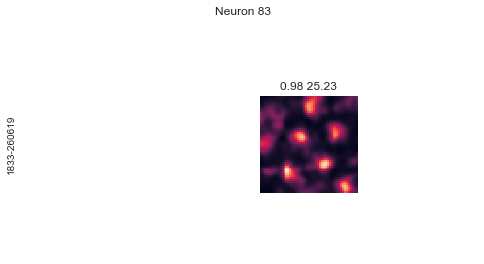

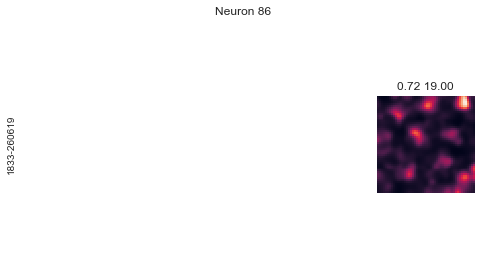

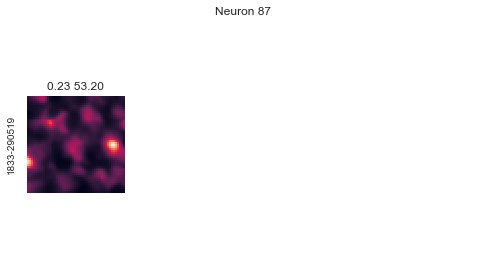

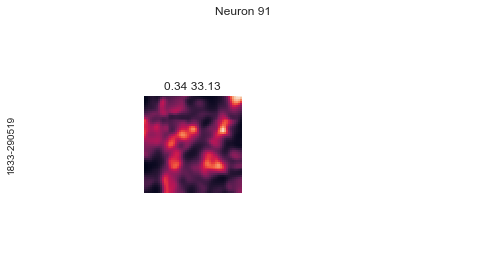

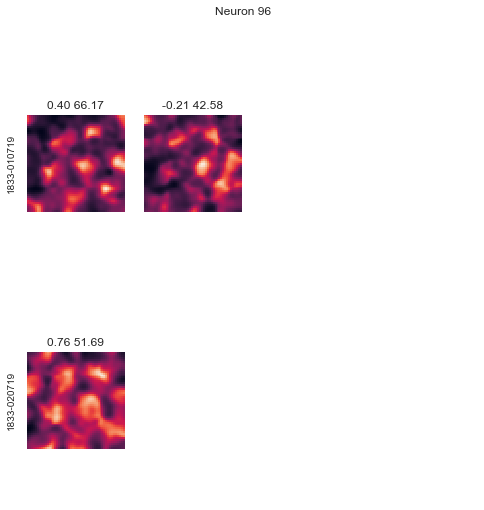

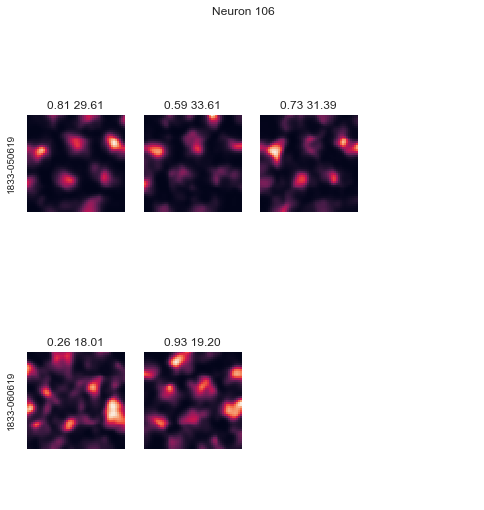

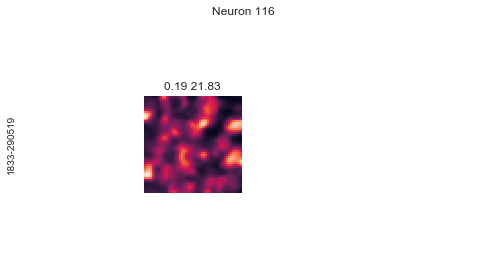

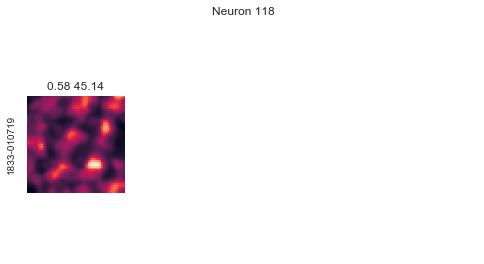

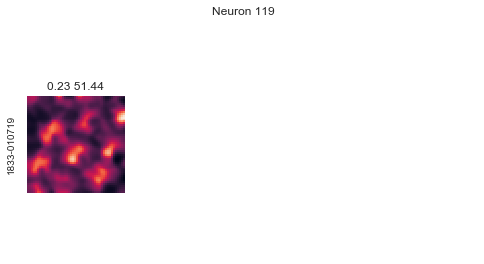

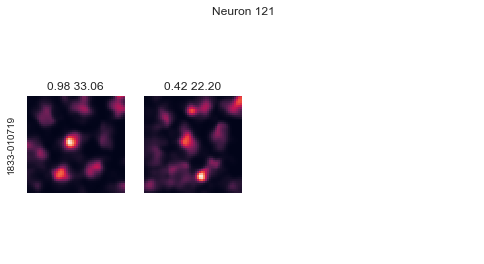

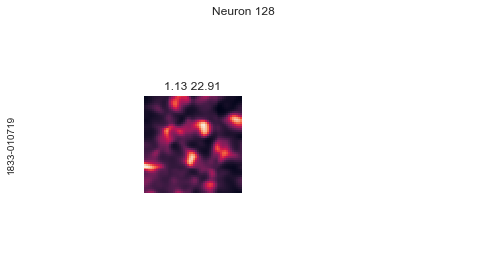

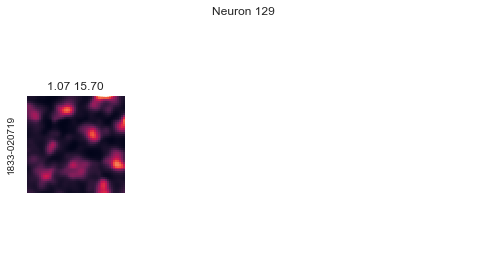

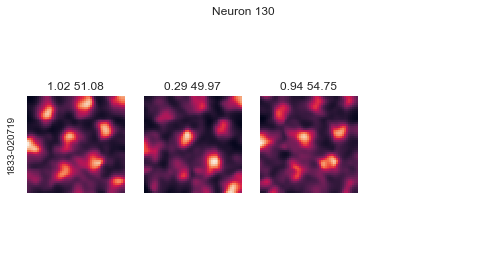

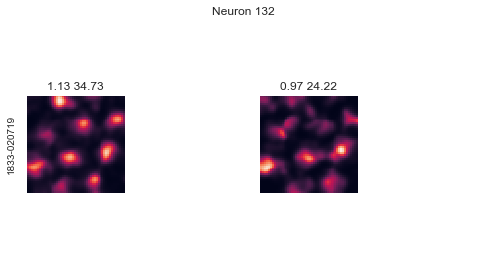

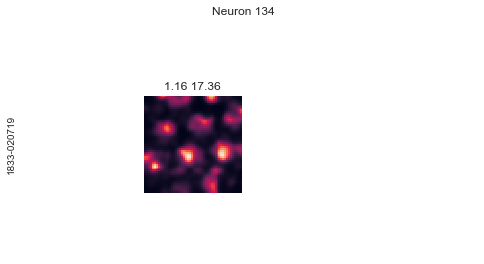

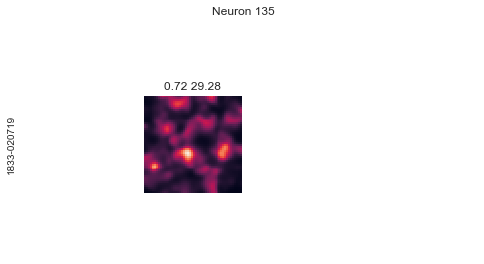

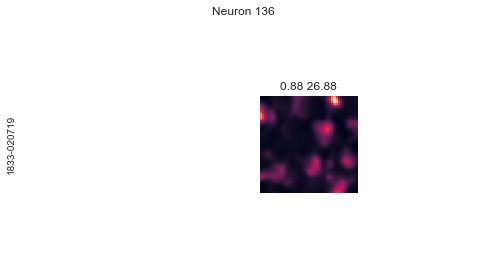

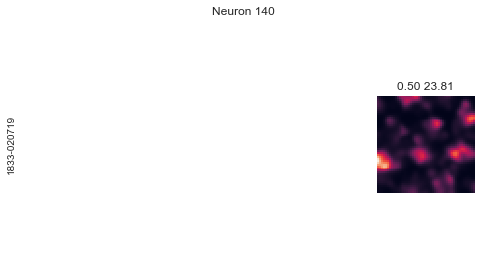

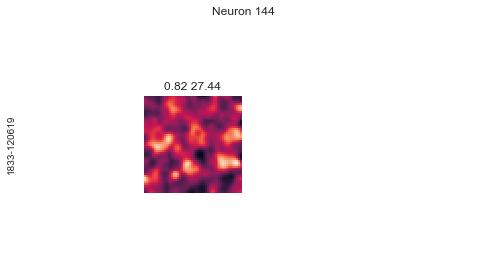

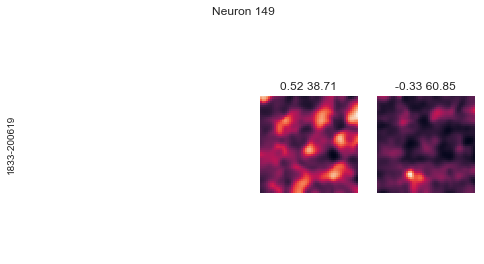

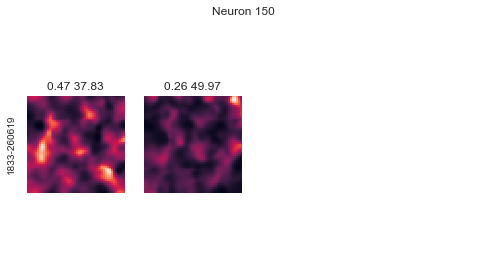

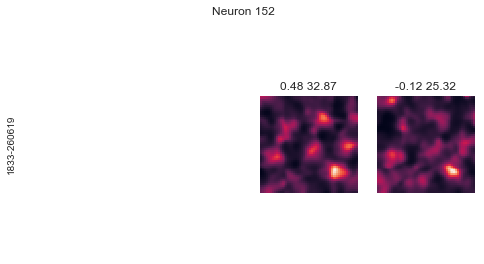

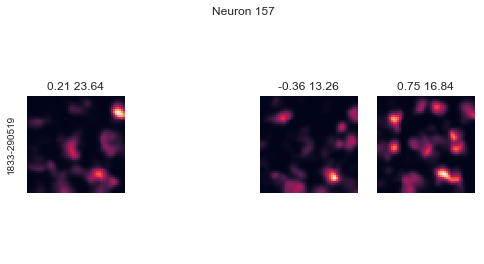

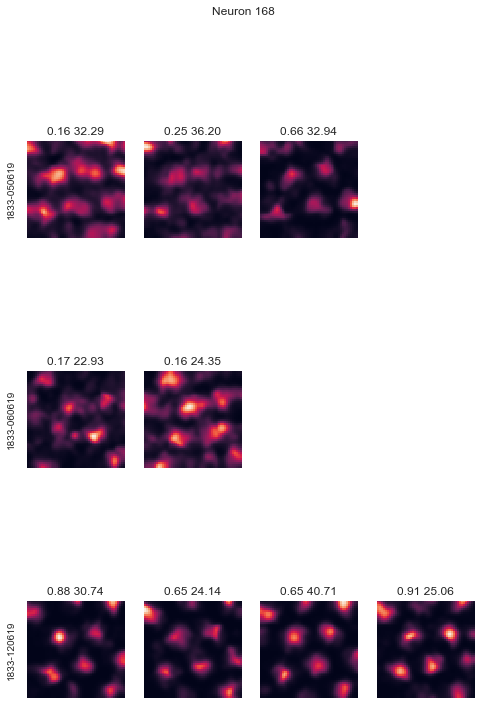

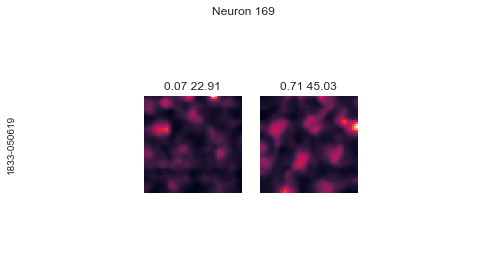

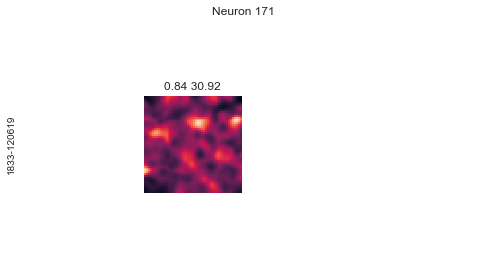

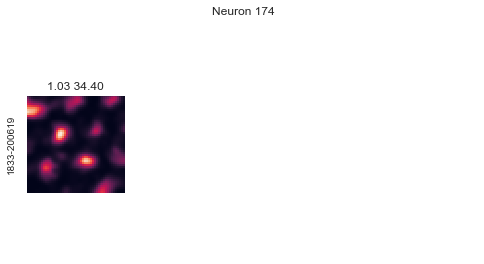

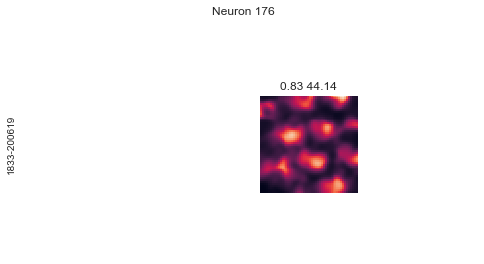

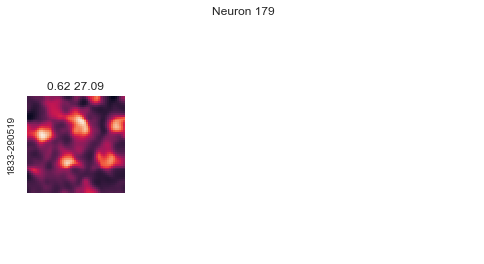

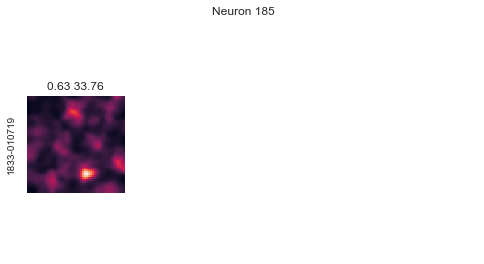

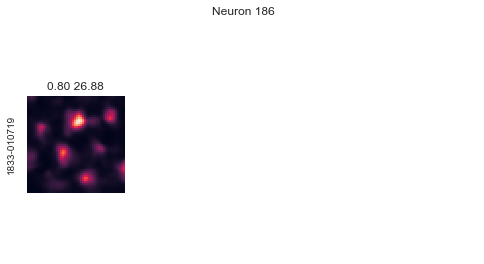

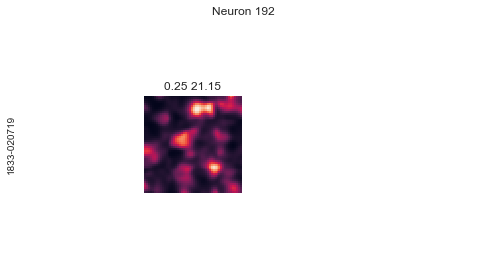

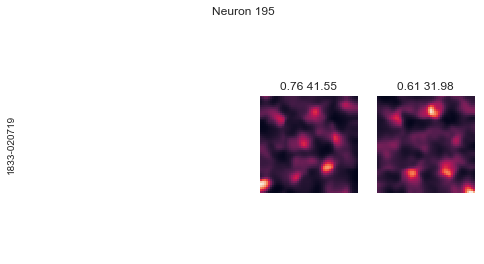

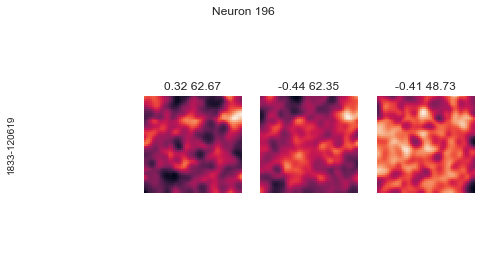

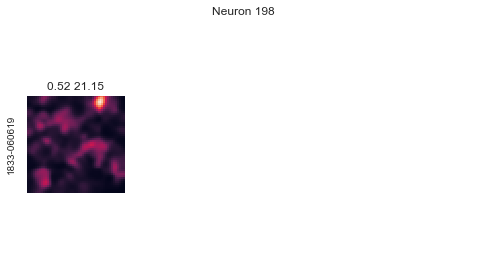

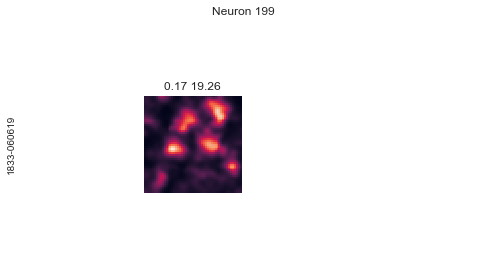

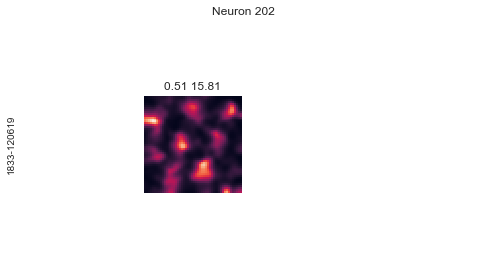

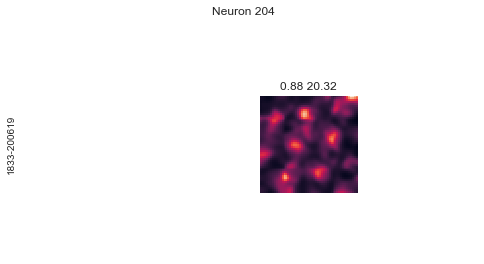

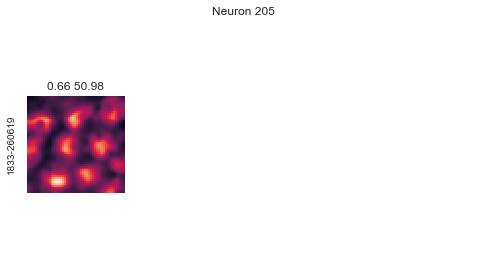

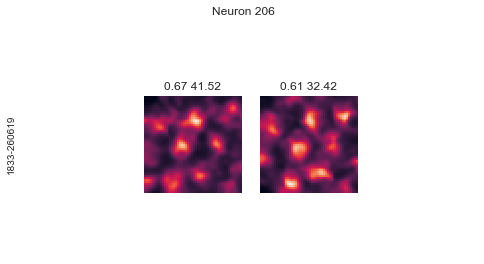

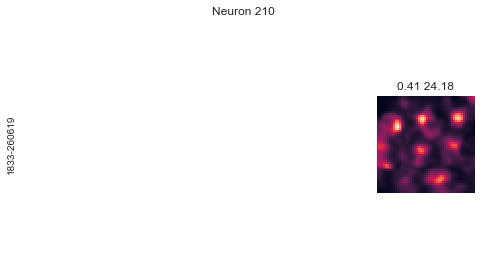

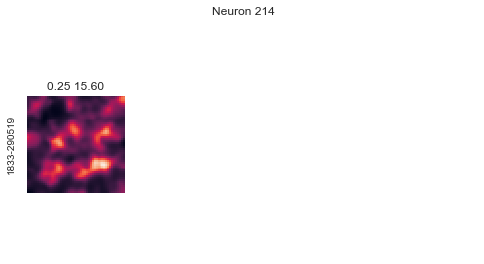

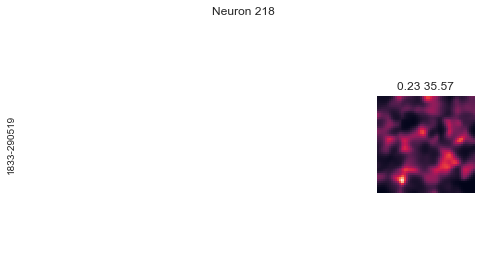

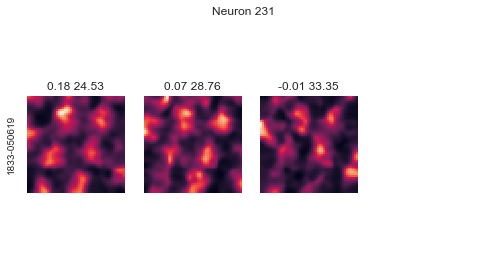

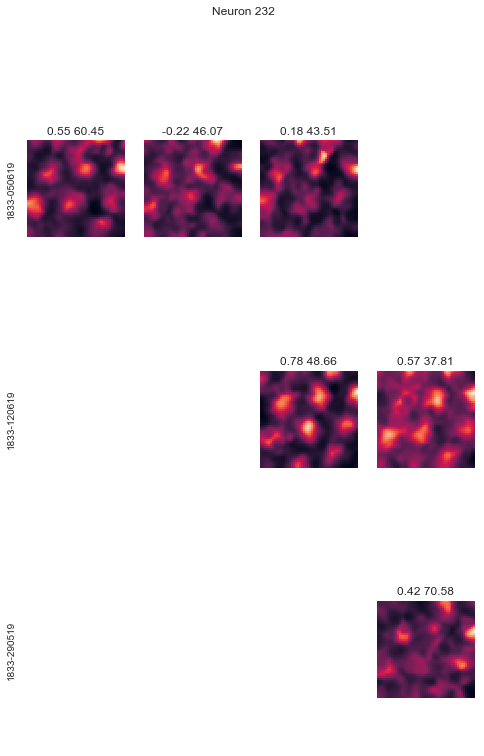

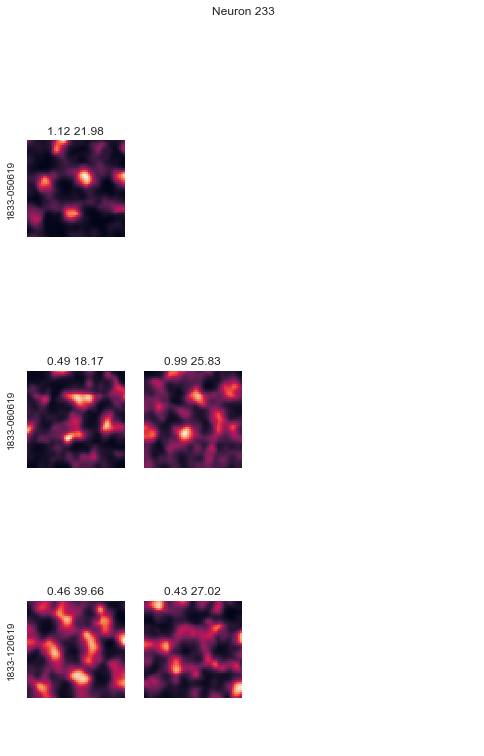

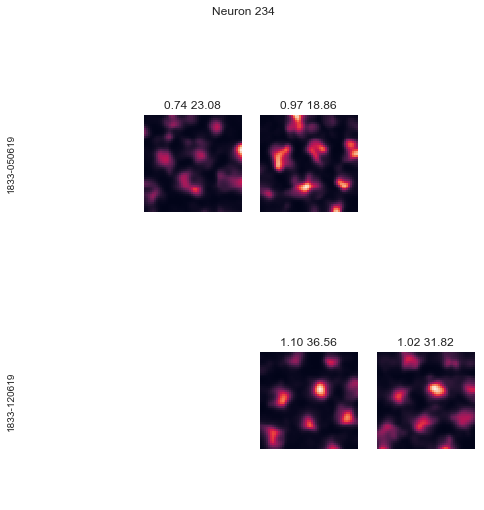

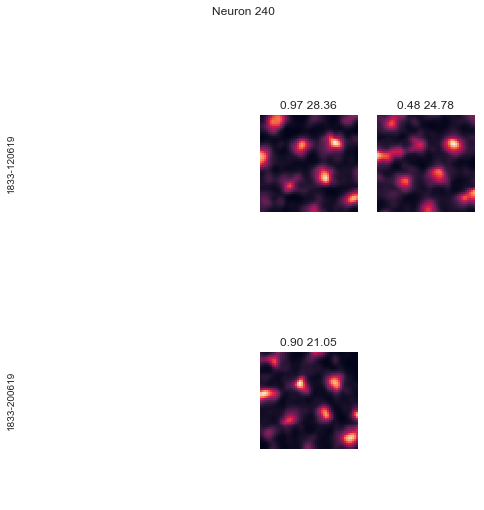

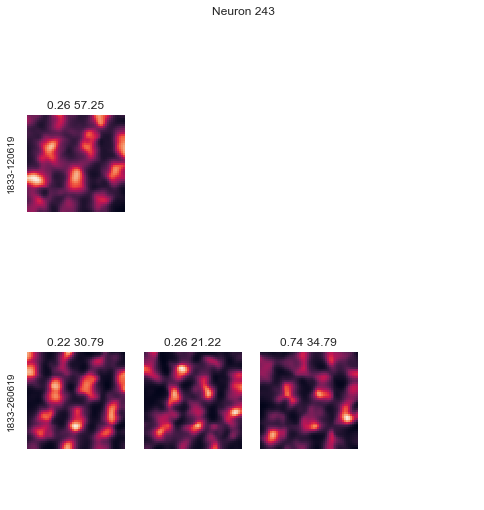

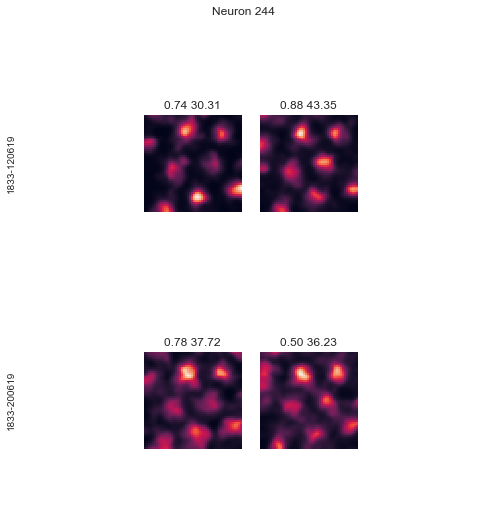

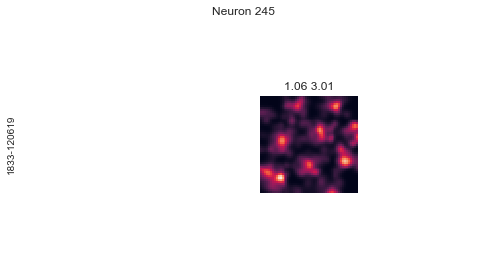

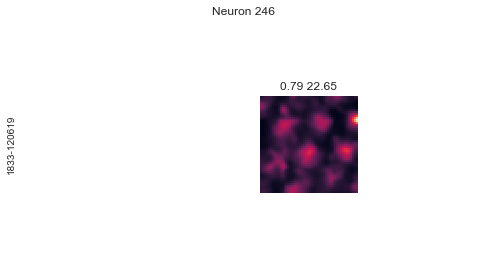

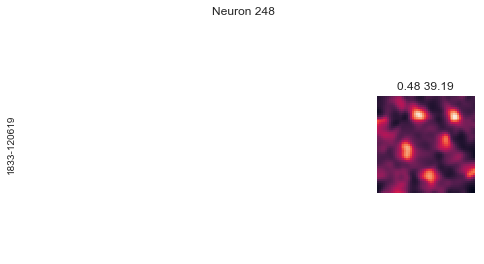

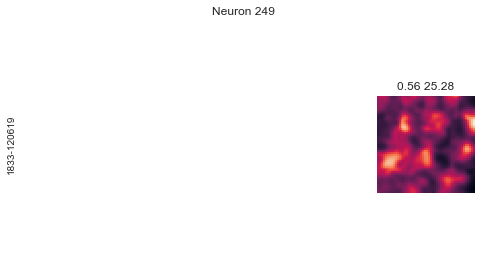

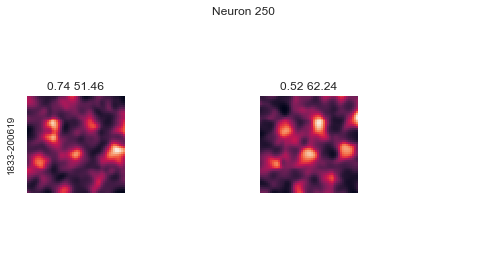

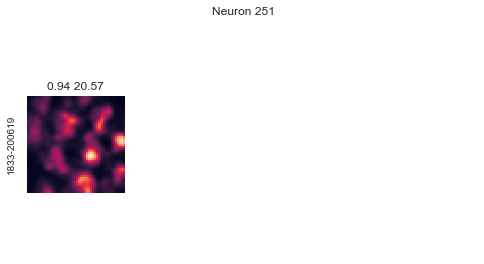

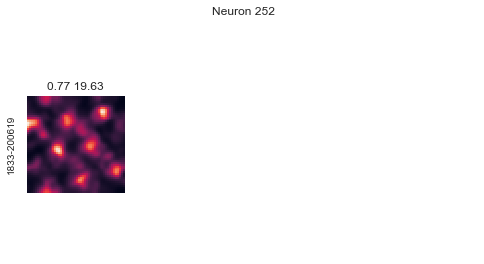

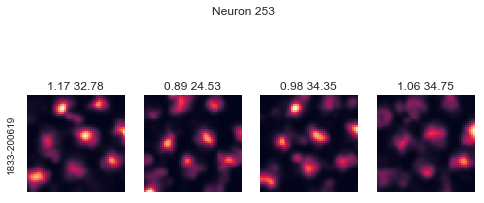

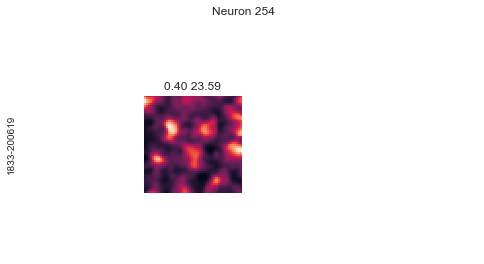

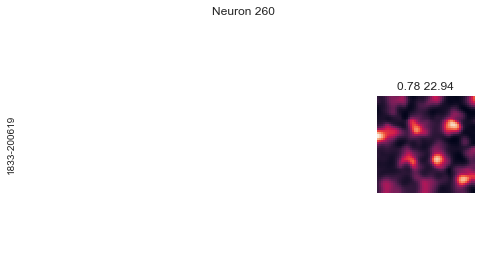

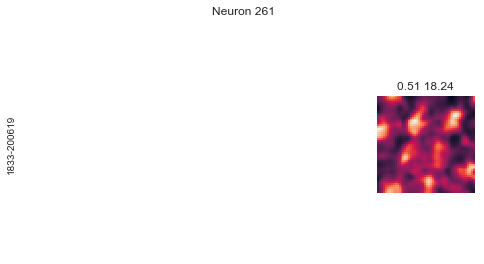

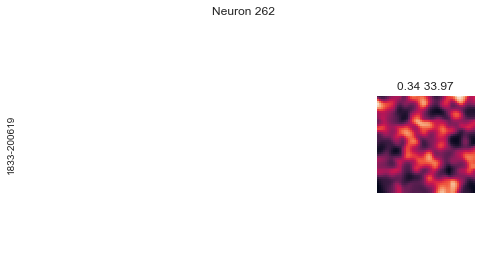

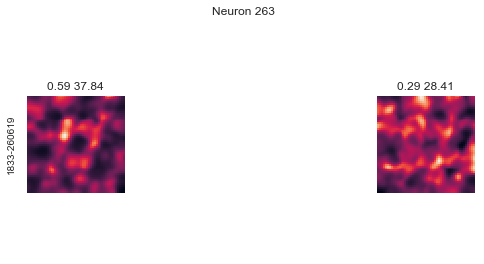

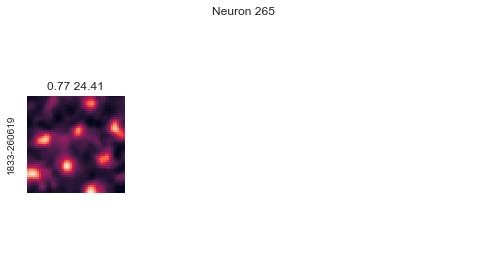

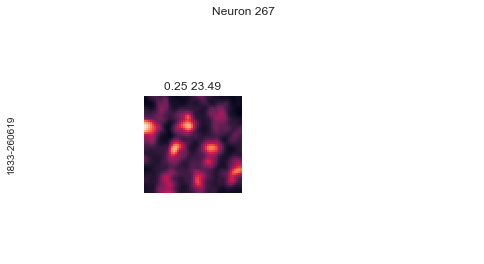

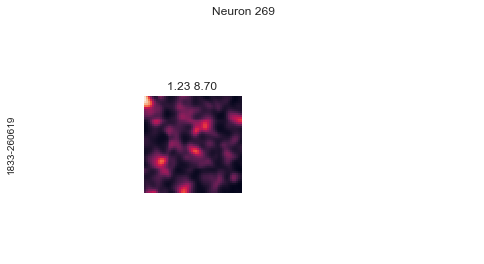

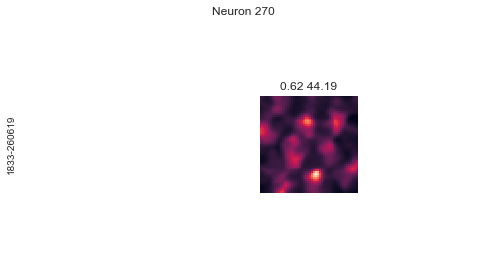

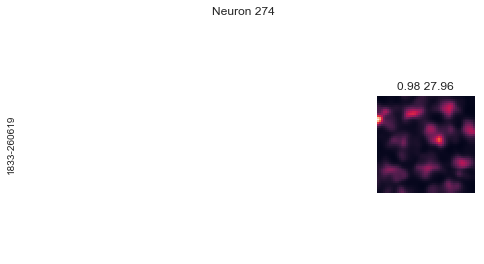

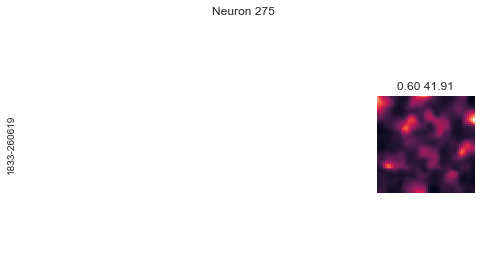

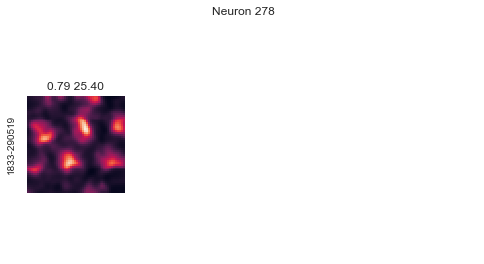

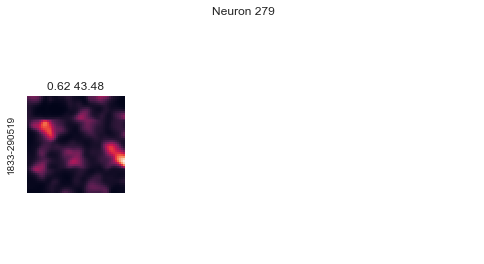

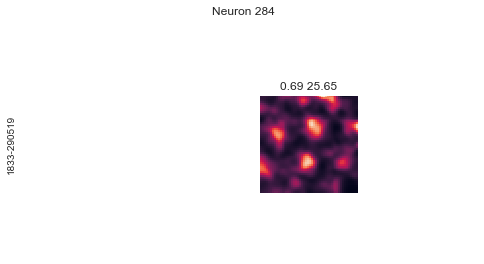

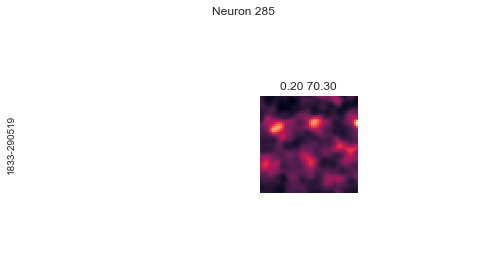

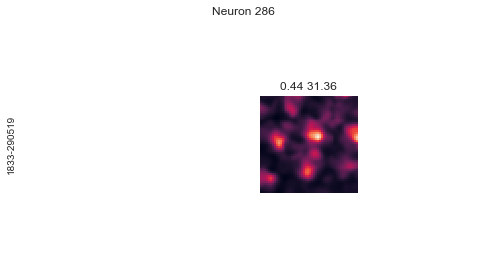

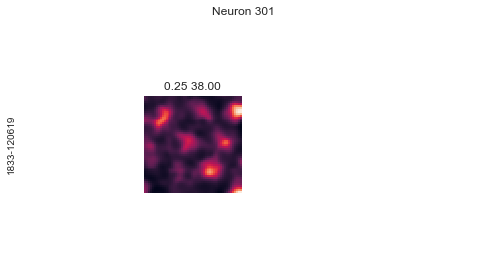

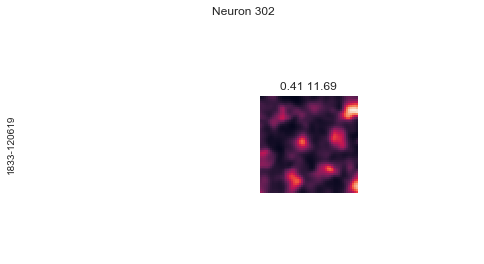

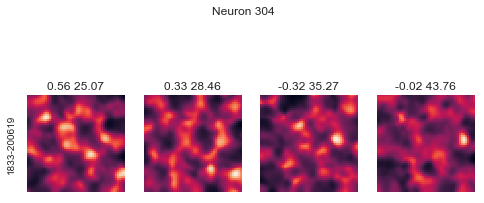

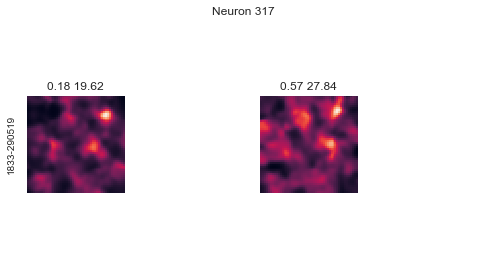

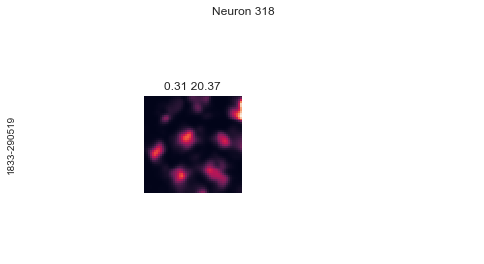

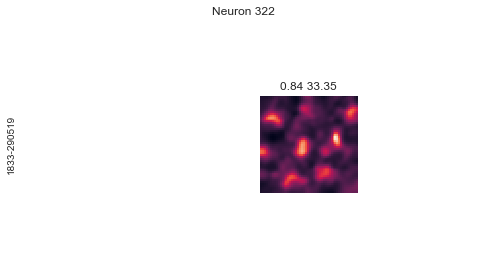

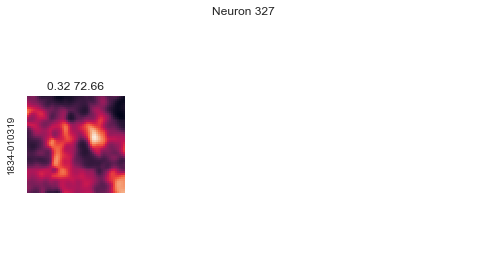

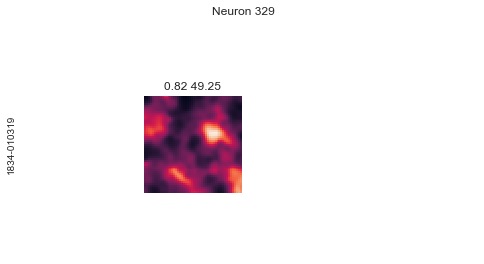

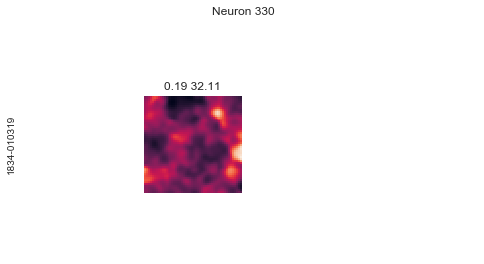

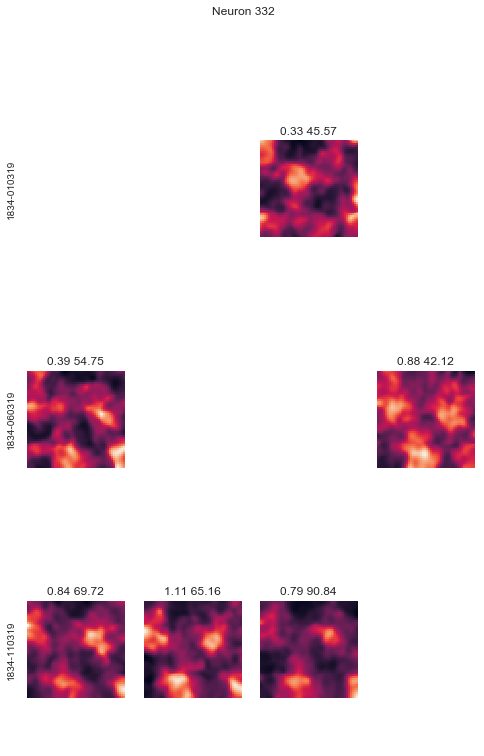

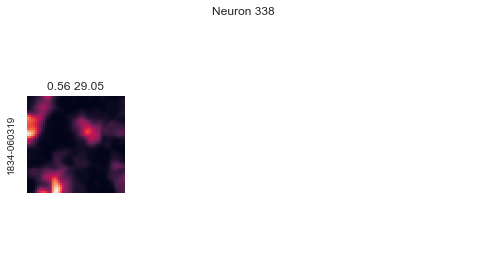

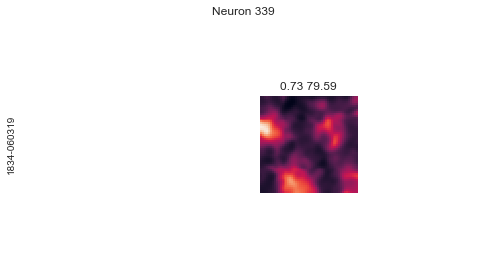

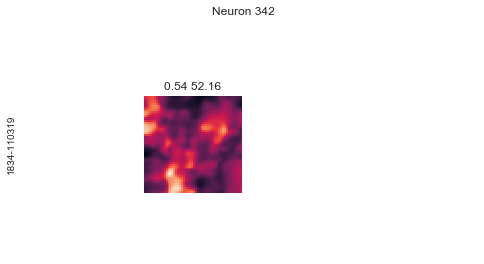

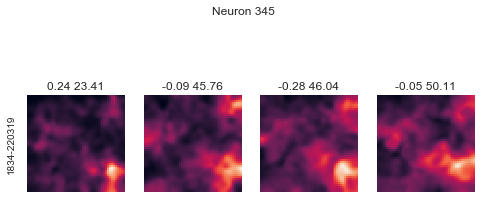

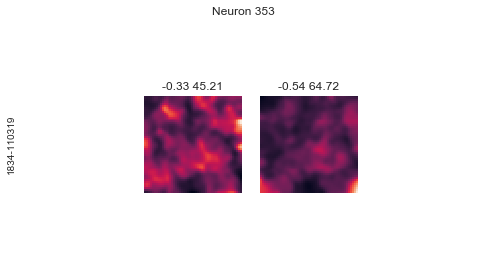

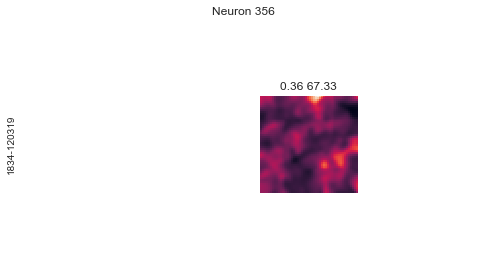

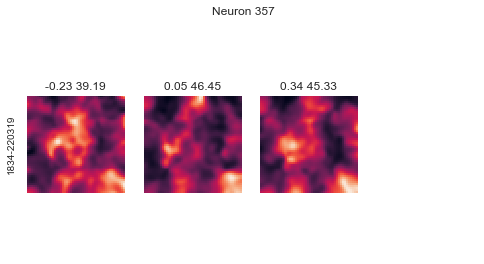

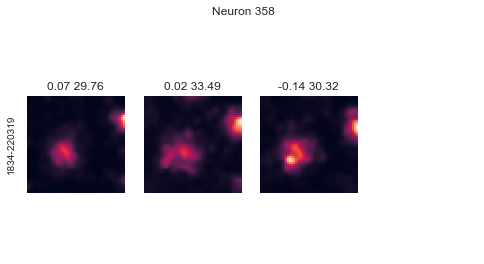

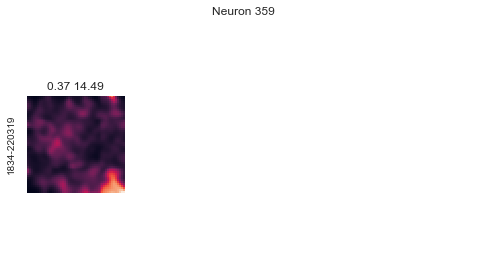

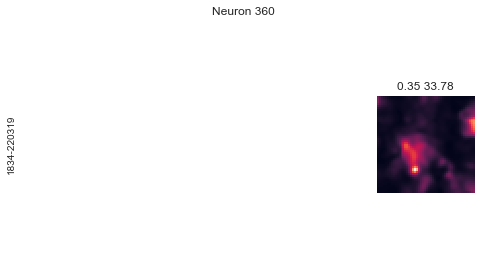

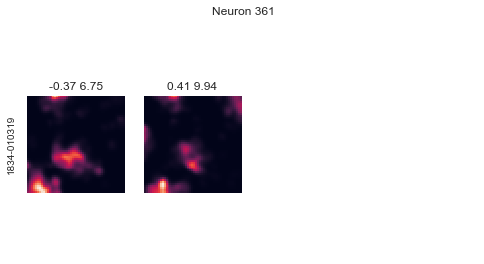

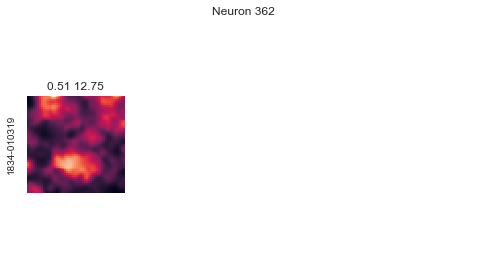

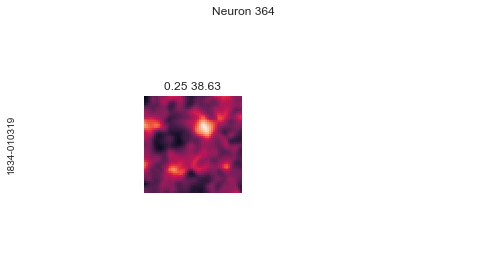

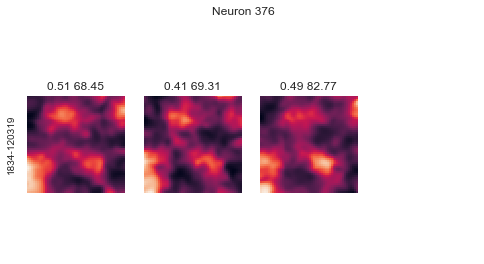

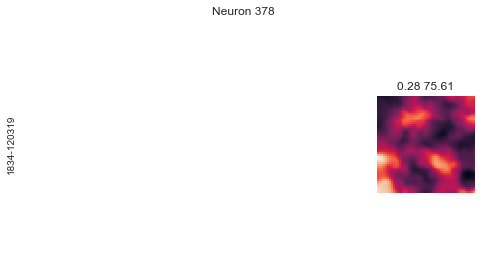

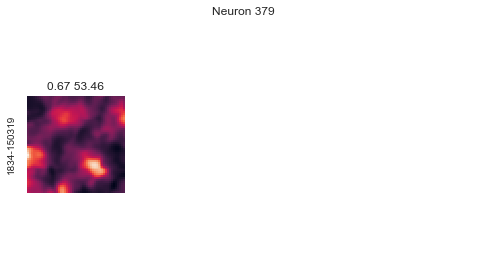

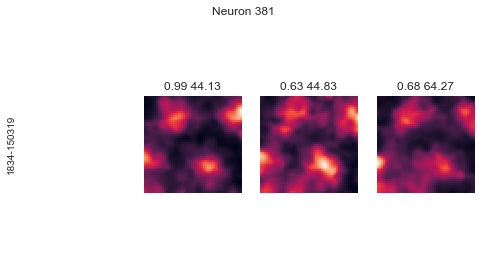

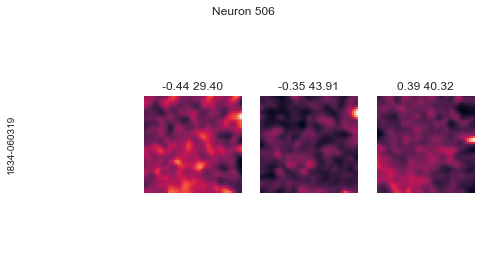

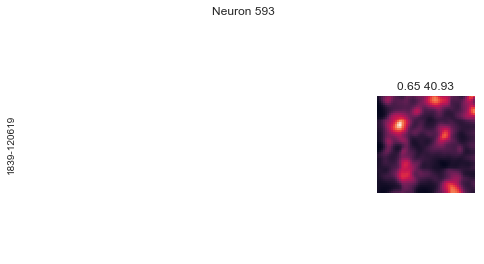

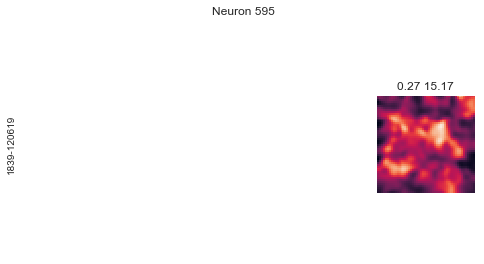

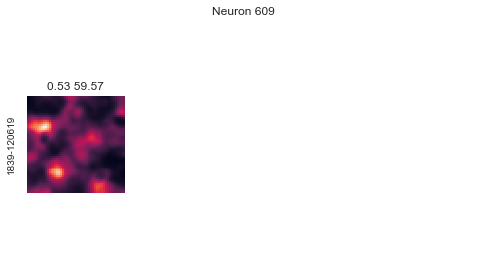

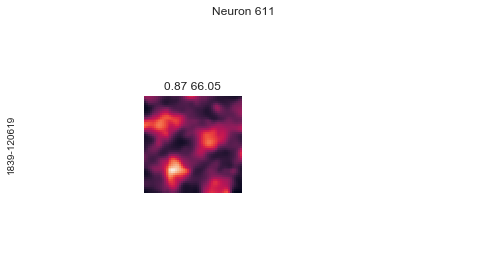

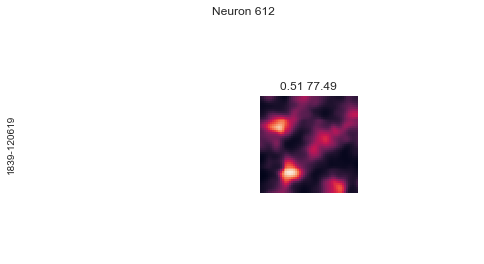

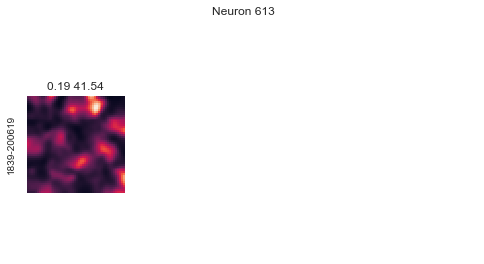

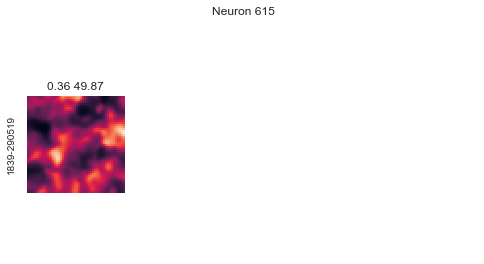

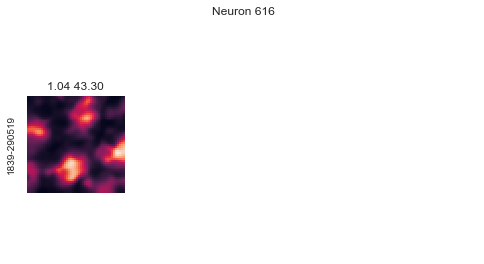

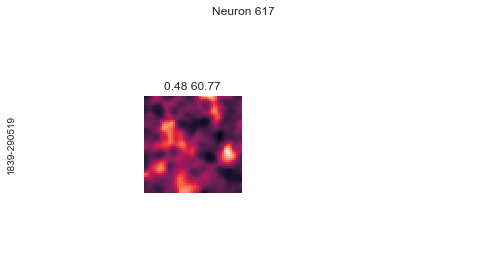

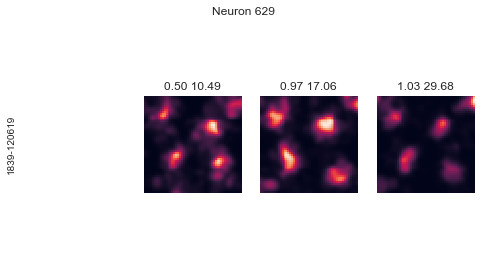

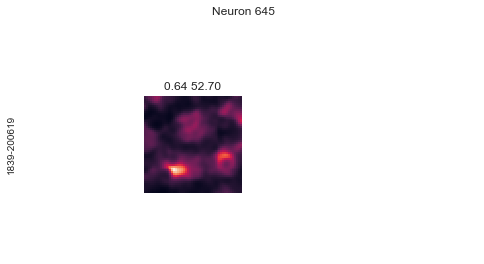

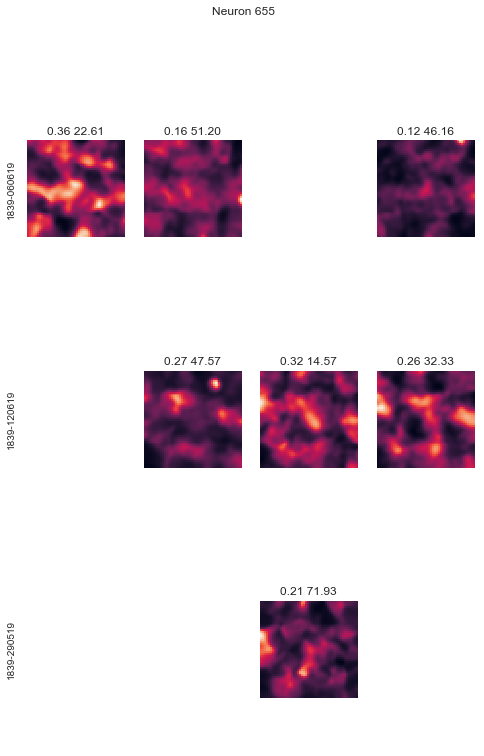

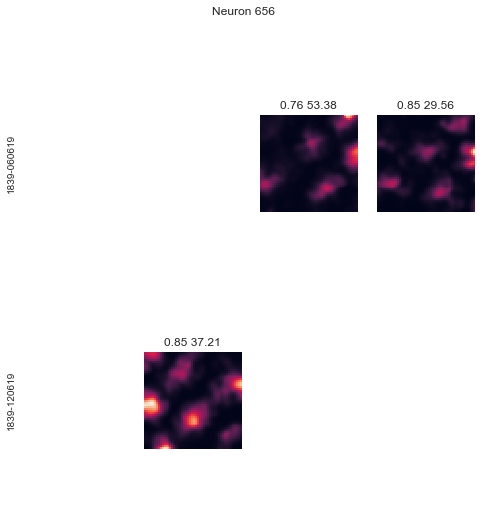

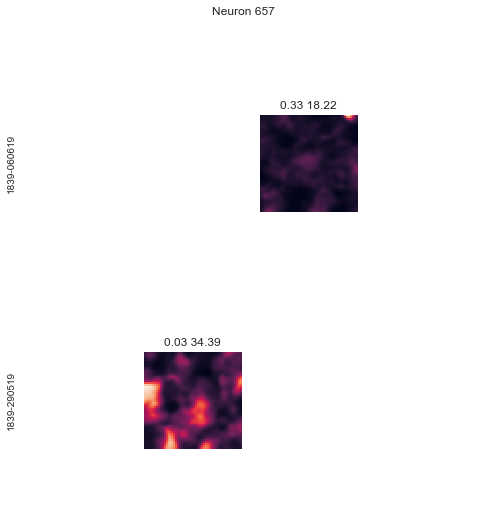

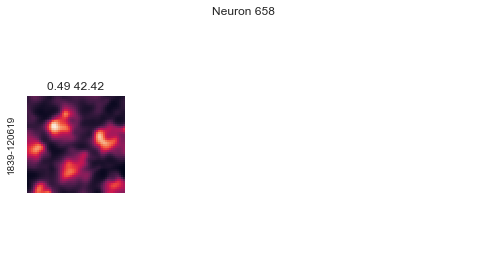

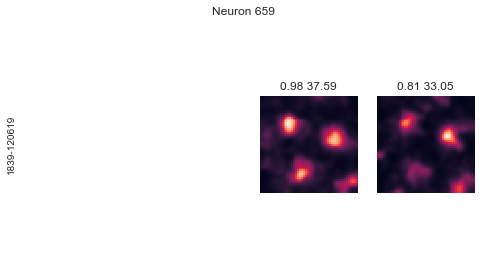

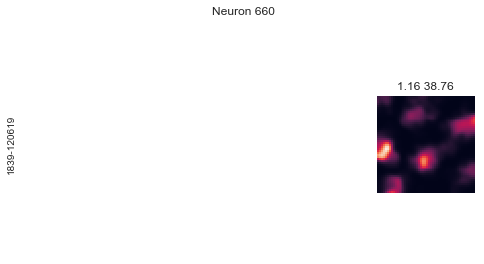

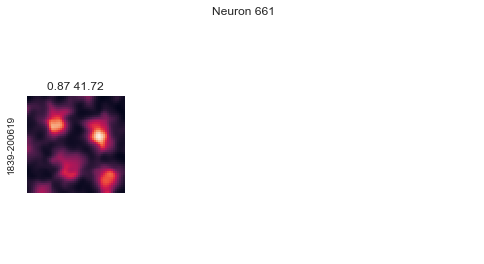

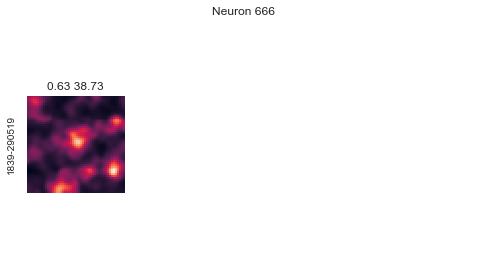

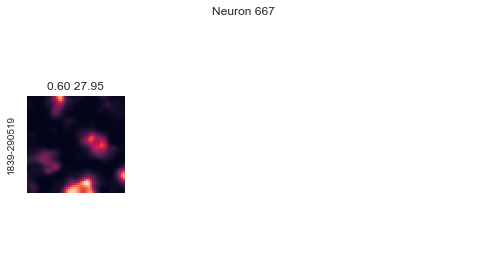

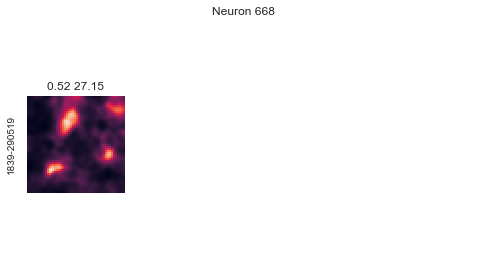

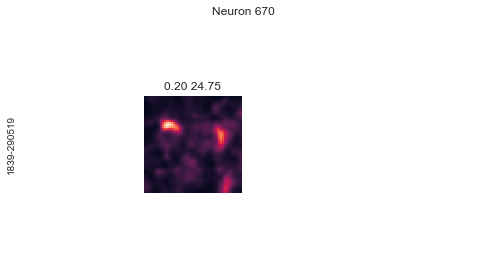

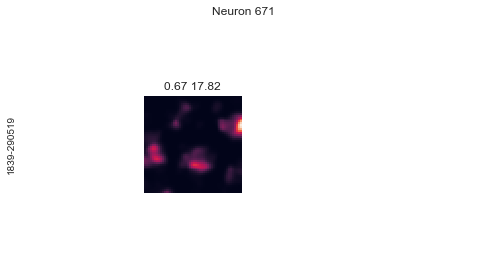

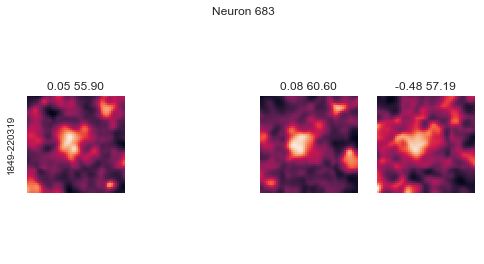

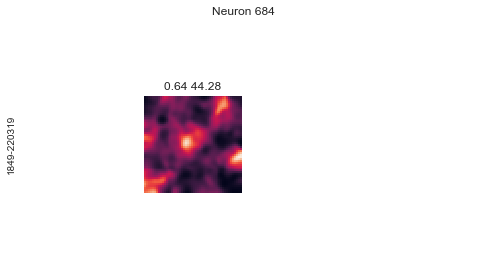

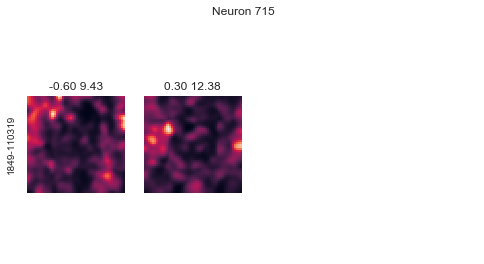

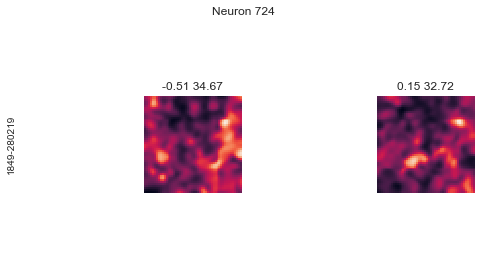

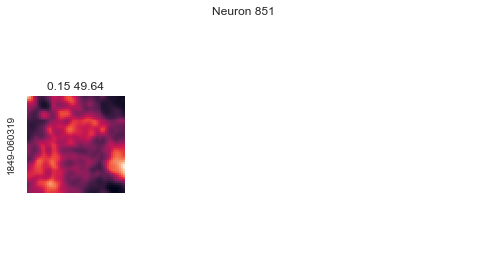

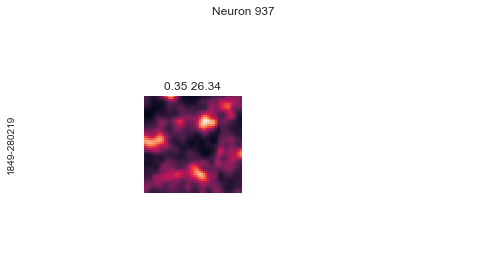

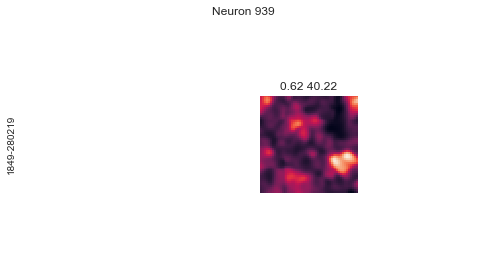

In [22]:
for id_num, sessions in once_a_gridcell_95.groupby('unit_idnum'):
    n_action = sessions.date.nunique()
    fig, axs = plt.subplots(n_action, 4, sharey=True, sharex=True, figsize=(8, n_action*4))
    sns.despine(left=True, bottom=True)
    fig.suptitle(f'Neuron {id_num}')
    if n_action == 1:
        axs = [axs]
    waxs = None
    for ax, (date, rows) in zip(axs, sessions.groupby('date')):
        entity = rows.iloc[0].entity
        ax[0].set_ylabel(f'{entity}-{date}')
        for _, row in rows.iterrows():
            action_id = row['action']
            channel_id = row['channel_group']
            unit_name = row['unit_name']
            rate_map = data_loader.rate_map(action_id, channel_id, unit_name, smoothing_low)
            idx = row.session_id
            ax[idx].imshow(rate_map, origin='lower')
            ax[idx].set_title(f'{row.gridness:.2f} {row.max_rate:.2f}')
            ax[idx].set_yticklabels([])
            ax[idx].set_xticklabels([])

# Top border score

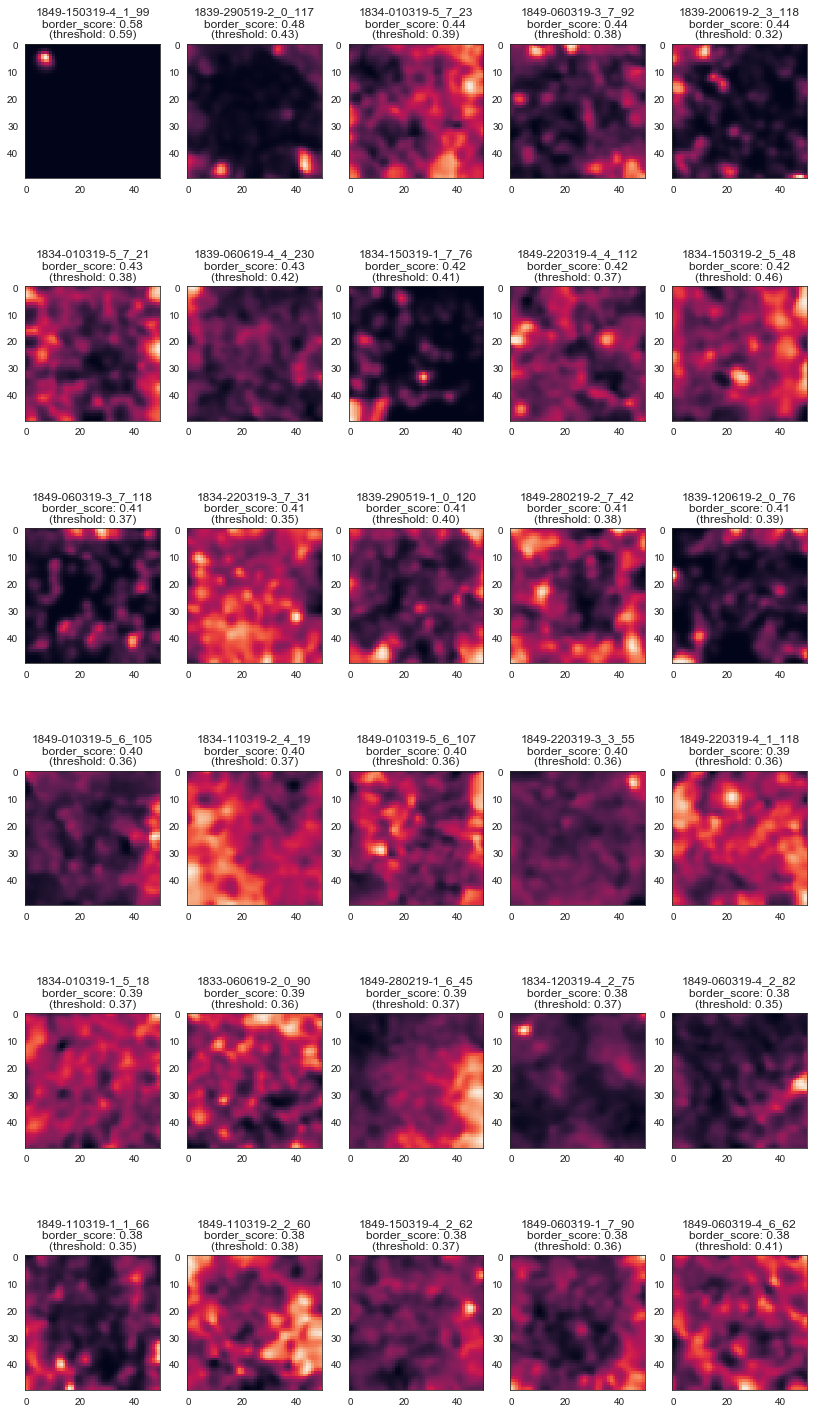

In [68]:
top("border_score")

# Top spatial information

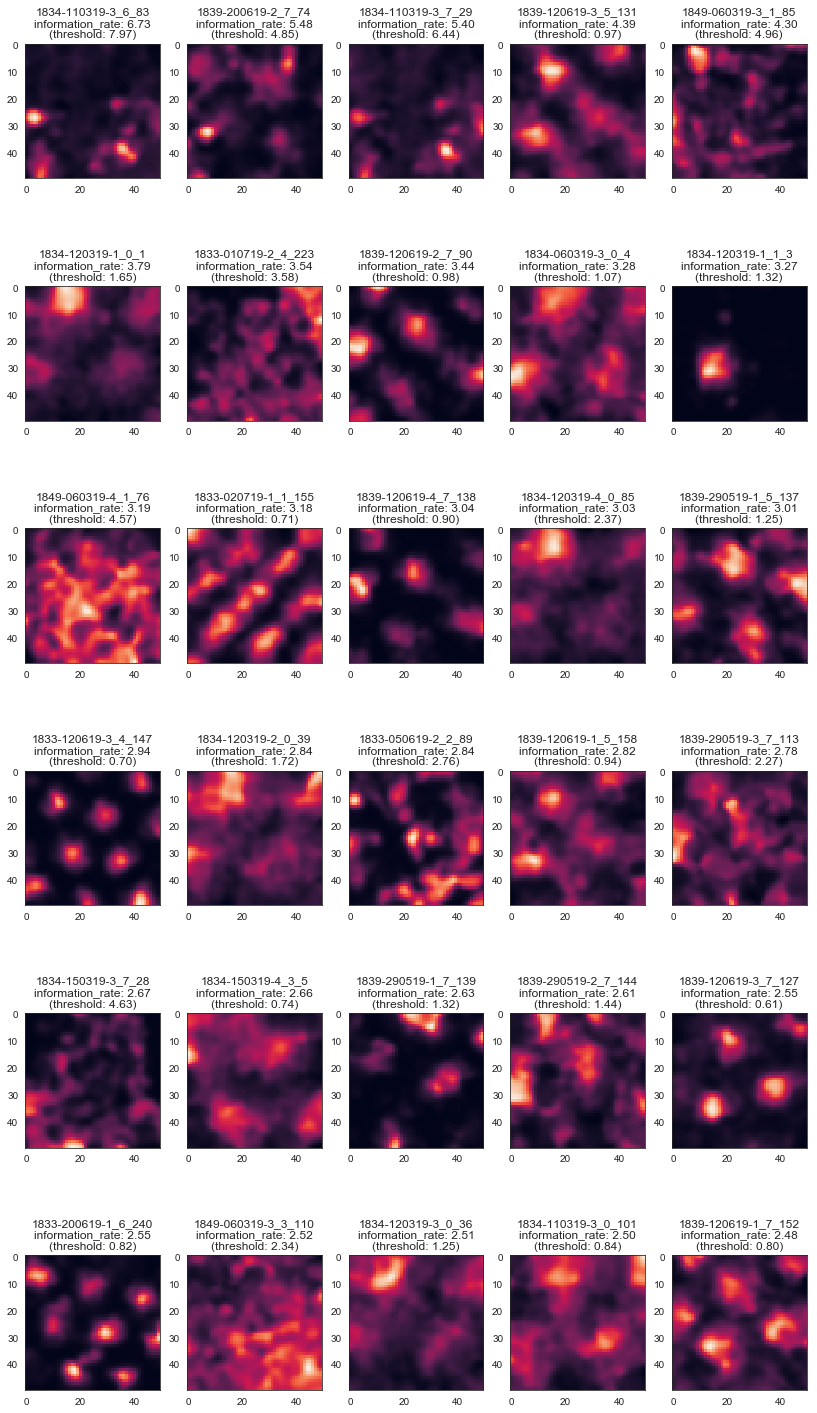

In [69]:
top("information_rate")

# Top head direction

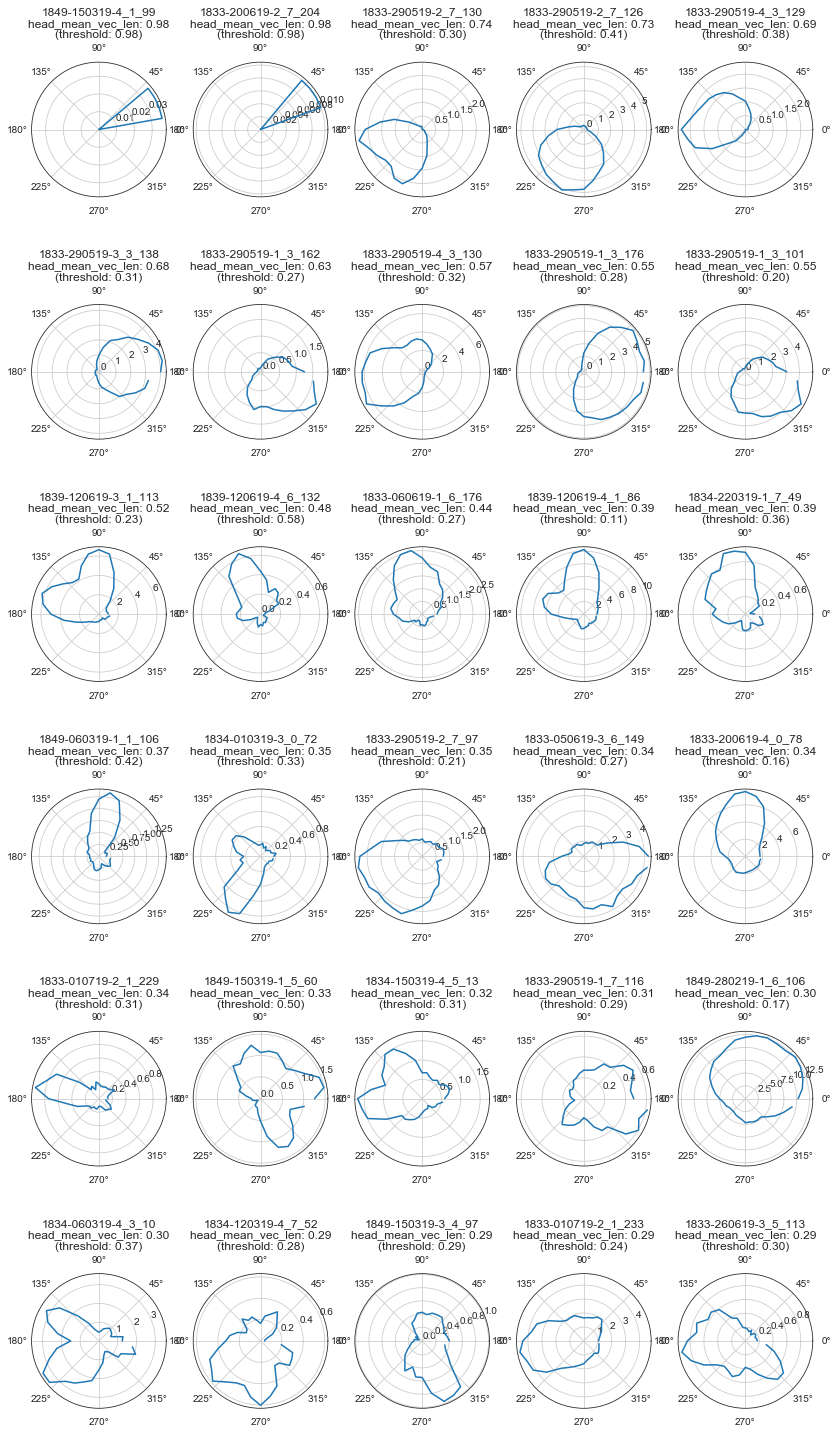

In [70]:
top("head_mean_vec_len")

# Top speed score

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/elephant/statistics.py:835: UserWarning: Instantaneous firing rate approximation contains negative values, possibly caused due to machine precision errors.
  warnings.warn("Instantaneous firing rate approximation contains "
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


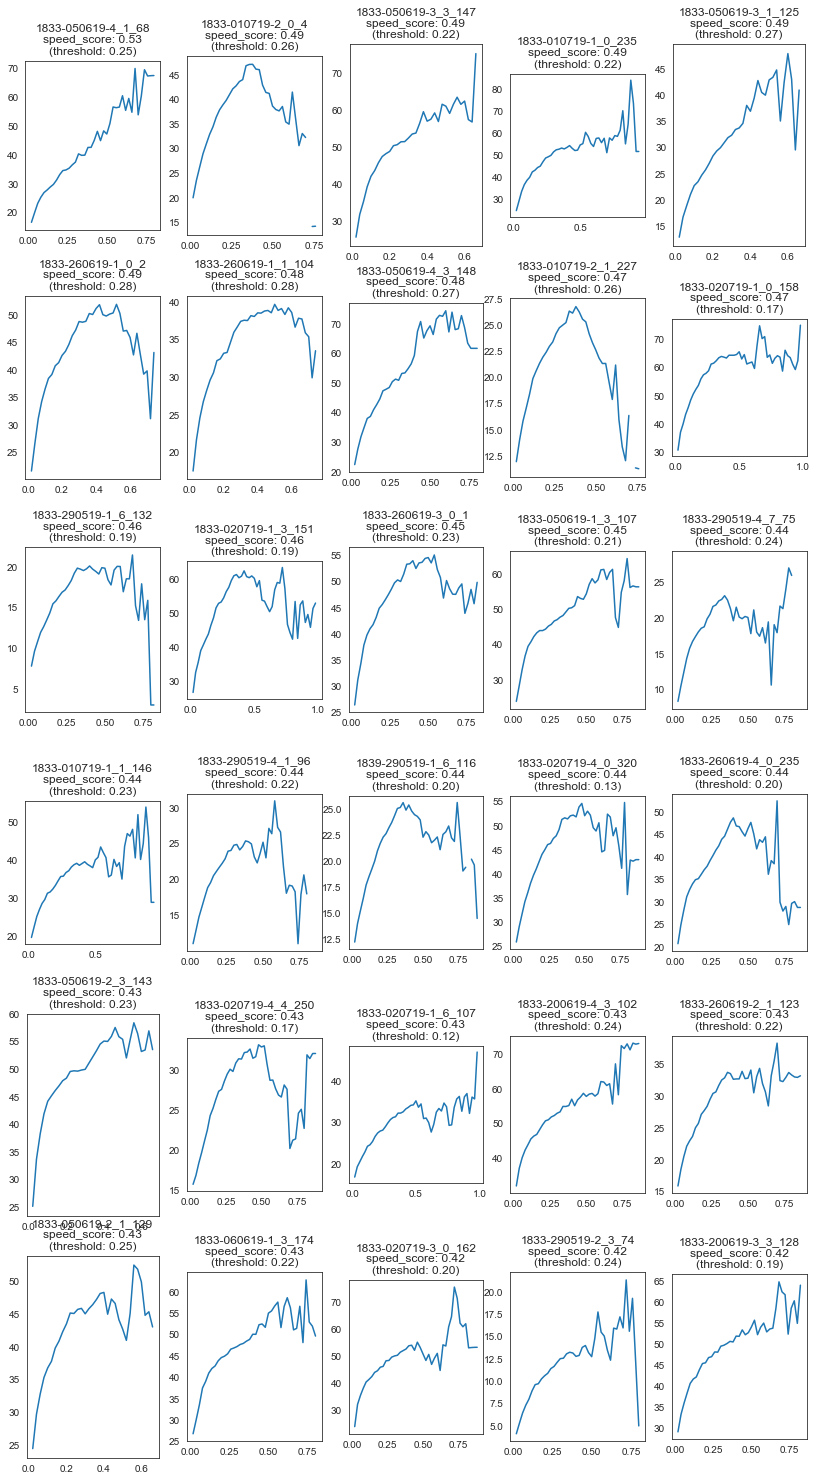

In [71]:
top("speed_score")